# Train a model with z encoder

### Please put your audio files in the folder  *./Pretrained_ Models_for_T2/training_ae*

### If the training process is termineated, rerun the sections "Import dependencies","Set paths" and "Train model" sequentially to continue training

## Check GPU setting

**Tensorflow-gpu 2.4 with Cuda 11.0 and CuDnn 8** in order to run by GPU.

In [1]:
import tensorflow as tf
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(tf.config.list_physical_devices('GPU'))
print('GPU',tf.test.is_gpu_available())

[]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU False


## Import dependencies

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import gin

import ddsp.training
from matplotlib import pyplot as plt
import IPython.display as ipd
import numpy as np
import utils

%matplotlib inline
sample_rate = 16000

print("importing successfully")

importing successfully


## Set paths

In [3]:
DRIVE_DIR = './Pretrained_Models_for_T2/training_ae'  
assert os.path.exists(DRIVE_DIR)

In [4]:
# create all directories leading up to the given directory that do not exist already. 
# If the given directory already exists, ignore the error.
DATA_DIR = os.path.join(DRIVE_DIR, 'data')
!mkdir -p "$DATA_DIR"
AUDIO_DIR = os.path.join(DATA_DIR, 'audio')
AUDIO_FILEPATTERN = AUDIO_DIR + '/*'
!mkdir -p "$AUDIO_DIR"
# folder to save the model
SAVE_DIR = os.path.join(DRIVE_DIR, 'ddsp_ae_instrument')
!mkdir -p "$SAVE_DIR"

In [5]:
# record the training data
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
!mkdir -p "$TRAIN_DIR"
TRAIN_TFRECORD = TRAIN_DIR + '/train.tfrecord'
TRAIN_TFRECORD_FILEPATTERN = TRAIN_DIR + '/train.tfrecord*'
print(TRAIN_TFRECORD_FILEPATTERN)

./Pretrained_Models_for_T2/training_ae/data/train/train.tfrecord*


## Prepare Dataset


In [ ]:
mp3_files = glob.glob(os.path.join(DRIVE_DIR, '*.mp3'))
wav_files = glob.glob(os.path.join(DRIVE_DIR, '*.wav'))
audio_files = mp3_files + wav_files

for fname in audio_files:
  target_name = os.path.join(AUDIO_DIR, 
                             os.path.basename(fname).replace(' ', '_'))
  print('Copying {} to {}'.format(fname, target_name))
  !cp "$fname" "$target_name"

We need to do some preprocessing on the raw audio you uploaded to get it into the correct format for training. This involves turning the full audio into short (4-second) examples, inferring the fundamental frequency (or "pitch") with [CREPE](http://github.com/marl/crepe), and computing the loudness. **These features will then be stored in a sharded [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) file for easier loading. Depending on the amount of input audio, this process usually takes a few minutes**.

In [ ]:
!ddsp_prepare_tfrecord \
--input_audio_filepatterns="$AUDIO_FILEPATTERN "\
--output_tfrecord_path="$TRAIN_TFRECORD" \
--num_shards=10 \
--alsologtostderr

In [ ]:
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)
PICKLE_FILE_PATH = os.path.join(SAVE_DIR, 'dataset_statistics.pkl')

utils.save_dataset_statistics(data_provider, PICKLE_FILE_PATH, batch_size=1)

Let's load the dataset in the `ddsp` library and have a look at one of the examples.

In [ ]:
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)

try:
  ex = next(iter(dataset))
except StopIteration:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

utils.specplot(ex['audio'])

f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')
ax[1].plot(x, ex['f0_hz'])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'])


In [ ]:
ipd.Audio(ex['audio'], rate = sample_rate)

## Train Model

We will now train a "ae instrument" model. This means the model is conditioned on the fundamental frequency (f0) and loudness with latent timbre feature z. If you uploaded audio of multiple instruemnts, the neural network you train will attempt to model all timbres, but will likely associate certain timbres with different f0 and loudness conditions. 

In [ ]:
%reload_ext tensorboard
import tensorboard as tb
tb.notebook.start('--logdir "{}"'.format(SAVE_DIR))

### We will now begin training. 

Note that we specify [gin configuration](https://github.com/google/gin-config) files for the both the model architecture ([solo_instrument.gin](TODO)) and the dataset ([tfrecord.gin](TODO)), which are both predefined in the library. You could also create your own. We then override some of the spefic params for `batch_size` (which is defined in in the model gin file) and the tfrecord path (which is defined in the dataset file). 

### Training Notes:

* Models typically perform well when the loss drops to the range of ~4.5-5.0.
* Depending on the dataset this can take anywhere from 5k-30k training steps usually.
* The default is set to 30k, but you can stop training at any time, and for timbre transfer, it's best to stop before the loss drops too far below ~5.0 to avoid overfitting.
* By default, checkpoints will be saved every 300 steps with a maximum of 10 checkpoints (at ~60MB/checkpoint this is ~600MB). Feel free to adjust these numbers depending on the frequency of saves you would like and space on your drive.
* If you're restarting a session and `DRIVE_DIR` points a directory that was previously used for training, training should resume at the last checkpoint.

In [ ]:
print(TRAIN_TFRECORD_FILEPATTERN)

### if you change the path at the begining of this notebook, your must replace the path *'./Pretrained_ Models_for_T2/training_ae/data/train/train.tfrecord*'* in the next cell by the previous print 

In [6]:
!ddsp_run \
  --mode=train \
  --alsologtostderr \
  --save_dir="$SAVE_DIR" \
  --gin_file=models/ae.gin \
  --gin_file=datasets/tfrecord.gin \
  --gin_param="TFRecordProvider.file_pattern='./Pretrained_Models_for_T2/training_ae/data/train/train.tfrecord*'"\
  --gin_param="batch_size=16" \
  --gin_param="train_util.train.num_steps=30000" \
  --gin_param="train_util.train.steps_per_save=200" \
  --gin_param="trainers.Trainer.checkpoints_to_keep=10"

2021-04-04 10:40:28.239414: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
I0404 10:40:38.707580 140648680019776 ddsp_run.py:176] Restore Dir: ./Pretrained_Models_for_T2/training_ae/ddsp_ae_instrument
I0404 10:40:38.708124 140648680019776 ddsp_run.py:177] Save Dir: ./Pretrained_Models_for_T2/training_ae/ddsp_ae_instrument
I0404 10:40:38.708470 140648680019776 resource_reader.py:50] system_path_file_exists:optimization/base.gin
E0404 10:40:38.708905 140648680019776 resource_reader.py:55] Path not found: optimization/base.gin
I0404 10:40:38.713663 140648680019776 resource_reader.py:50] system_path_file_exists:eval/basic.gin
E0404 10:40:38.714269 140648680019776 resource_reader.py:55] Path not found: eval/basic.gin
I0404 10:40:38.720917 140648680019776 ddsp_run.py:147] Using operative config: ./Pretrained_Models_for_T2/training_ae/ddsp_ae_instrument/operative_config-0.gin
I0404 10:40:38.736929 140648680019776 resource_

## Resynthesis

Check how well the model reconstructs the training data

Original Audio
Resynthesis

 Z value: tf.Tensor(
[[[ 0.85066575  0.25306818  0.68844485 ... -0.09065358 -0.39819115
   -1.262724  ]
  [ 0.8307215   0.28882864  0.7441398  ... -0.15825897 -0.40852138
   -1.3906956 ]
  [ 0.8107772   0.3245891   0.7998347  ... -0.22586438 -0.41885164
   -1.5186672 ]
  ...
  [ 2.9974606  -1.4120704  -0.7623534  ...  1.9218245   0.19296497
   -1.7339048 ]
  [ 2.9974606  -1.4120704  -0.7623534  ...  1.9218245   0.19296497
   -1.7339048 ]
  [ 2.9974606  -1.4120704  -0.7623534  ...  1.9218245   0.19296497
   -1.7339048 ]]], shape=(1, 1000, 16), dtype=float32)


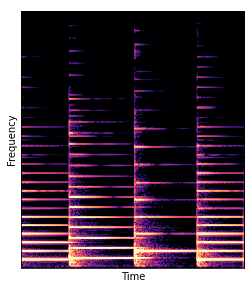

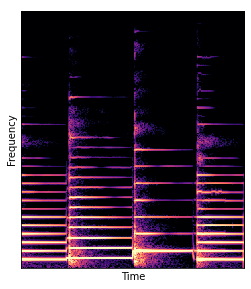

In [7]:
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_batch(batch_size=1, shuffle=False)

try:
  batch = next(iter(dataset))
except OutOfRangeError:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

# Parse the gin config.
gin_file = os.path.join(SAVE_DIR, 'operative_config-0.gin')
gin.parse_config_file(gin_file)

# Load model
model = ddsp.training.models.Autoencoder()
model.restore(SAVE_DIR)

# Resynthesize audio.
outputs = model(batch, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
audio = batch['audio']

print('Original Audio')
utils.specplot(audio)

print('Resynthesis')
utils.specplot(audio_gen)

print('\n','Z value:',outputs['z'])

In [8]:
print('Original Audio')
ipd.Audio(audio[0], rate = sample_rate)

Original Audio


In [9]:
print('Resynthesis')
ipd.Audio(audio_gen[0], rate = sample_rate)

Resynthesis


## SAVE Checkpoint

Below you can download the final checkpoint. You are now ready to use it in the [DDSP Timbre Tranfer Colab](https://colab.research.google.com/github/magenta/ddsp/blob/master/ddsp/colab/demos/timbre_transfer.ipynb).

In [10]:
CHECKPOINT_ZIP = 'my_ae_instrument.zip'
# save the latest checkpoint file
latest_checkpoint_fname = os.path.basename(tf.train.latest_checkpoint(SAVE_DIR))
!cd "$SAVE_DIR" && zip $CHECKPOINT_ZIP $latest_checkpoint_fname* operative_config-0.gin dataset_statistics.pkl
!cp "$SAVE_DIR/$CHECKPOINT_ZIP" ./ 

  adding: ckpt-15000.data-00000-of-00001 (deflated 7%)
  adding: ckpt-15000.index (deflated 79%)
  adding: operative_config-0.gin (deflated 75%)
  adding: dataset_statistics.pkl (deflated 31%)
